<a href="https://colab.research.google.com/github/Moe-phantom/Moe-phantom/blob/main/LIAR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datasets

dataset = "chengxuphd/liar2"
dataset = datasets.load_dataset(dataset)

statement_train, y_train = dataset["train"]["statement"], dataset["train"]["label"]
statement_val, y_val = dataset["validation"]["statement"], dataset["validation"]["label"]
statement_test, y_test = dataset["test"]["statement"], dataset["test"]["label"]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.csv:   0%|          | 0.00/19.0M [00:00<?, ?B/s]

valid.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/18369 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2297 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2296 [00:00<?, ? examples/s]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Hugging Face dataset object to a Pandas DataFrame
df = pd.DataFrame(dataset['train'])

# Show the first 5 rows
print("Columns available:", df.columns)
df.head()

Columns available: Index(['id', 'label', 'statement', 'date', 'subject', 'speaker',
       'speaker_description', 'state_info', 'true_counts',
       'mostly_true_counts', 'half_true_counts', 'mostly_false_counts',
       'false_counts', 'pants_on_fire_counts', 'context', 'justification'],
      dtype='object')


,id,label,statement,date,subject,speaker,speaker_description,state_info,true_counts,mostly_true_counts,half_true_counts,mostly_false_counts,false_counts,pants_on_fire_counts,context,justification
0,13847,5,"90 percent of Americans ""support universal bac...","October 2, 2017",government regulation;polls and public opinion...,chris abele,"Chris Abele is Milwaukee County Executive, a p...",wisconsin,1,4,5,3,5,2,a tweet,"""Universal"" is the term for background checks ..."
1,13411,1,Last year was one of the deadliest years ever ...,"May 19, 2017",after the fact;congress;criminal justice;histo...,thom tillis,Thom Tillis is a Republican who serves as U.S....,north carolina,0,2,7,3,2,0,a press release supporting the Back The Blue A...,"Sen. Thom Tillis, a North Carolina Republican,..."
2,10882,0,"Bernie Sanders's plan is ""to raise your taxes ...","October 28, 2015",taxes,chris christie,"Chris Christie announced June 6, 2023 that he ...",national,21,20,27,11,17,8,"Boulder, Colo","Christie said that Sanders’s plan is ""to raise..."
3,20697,4,Voter ID is supported by an overwhelming major...,"December 8, 2021",voter id laws,lee zeldin,Lee Zeldin is a Republican representing New Yo...,new york,1,2,0,0,0,0,a Tweet,Zeldin claimed voter identification requiremen...
4,6095,2,"Says Barack Obama ""robbed Medicare (of) $716 b...","August 12, 2012",federal budget;history;medicare;retirement,mitt romney,Mitt Romney is a U.S. senator from Utah. He ra...,national,31,33,58,35,32,19,"an interview on ""60 Minutes""","Romney said, ""There's only one president that ..."


label
1    5284
3    2967
2    2882
4    2743
0    2425
5    2068
Name: count, dtype: int64


/tmp/ipython-input-2721374368.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


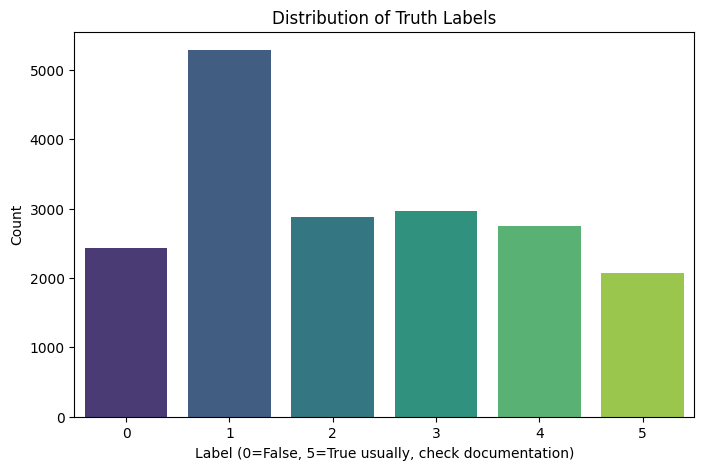

In [ ]:
# Count the labels
label_counts = df['label'].value_counts()
print(label_counts)

# Visualize it
plt.figure(figsize=(8,5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of Truth Labels')
plt.xlabel('Label (0=False, 5=True usually, check documentation)')
plt.ylabel('Count')
plt.show()

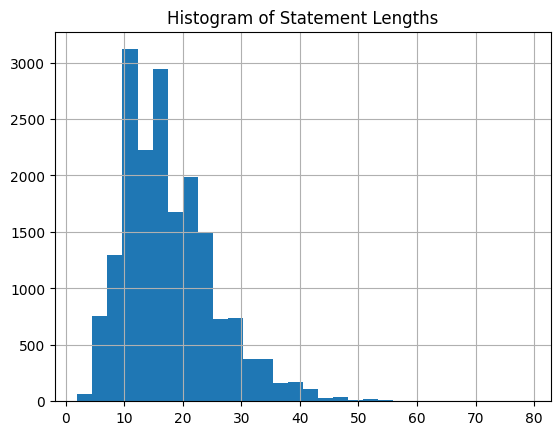

Max length: 79
Average length: 17.696826174533182


In [ ]:
# Calculate length of each statement
seq_len = [len(i.split()) for i in df['statement']]
pd.Series(seq_len).hist(bins=30)
plt.title('Histogram of Statement Lengths')
plt.show()

print(f"Max length: {max(seq_len)}")
print(f"Average length: {sum(seq_len)/len(seq_len)}")

In [ ]:
# Who talks the most?
print(df['speaker'].value_counts().head(10))

# Where do these statements come from? (Tweets? Debates?)
print(df['context'].value_counts().head(10))

speaker
facebook posts     1879
viral image         900
donald trump        780
bloggers            580
instagram posts     498
barack obama        475
hillary clinton     245
joe biden           218
mitt romney         167
scott walker        159
Name: count, dtype: int64
context
a Facebook post      2182
a tweet               947
an Instagram post     513
an interview          431
a speech              420
a press release       361
a news release        332
a TV ad               295
a blog post           251
a campaign ad         229
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Label Mapping (Functionality: Grouping similar truths)
def map_to_binary(label):
    # FAKE GROUP: False(0), Barely-True(4), Pants-Fire(5)
    if label in [0, 4, 5]: return 0
    # REAL GROUP: Half-True(1), Mostly-True(2), True(3)
    else: return 1

y_train = np.array([map_to_binary(l) for l in dataset['train']['label']])
y_val   = np.array([map_to_binary(l) for l in dataset['validation']['label']])
y_test  = np.array([map_to_binary(l) for l in dataset['test']['label']])

# 2. Text Processing (Functionality: Text to Numbers)
# We train a NEW tokenizer because LIAR vocabulary is different from Reuters
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['train']['statement'])

vocab_size = len(tokenizer.word_index) + 1
maxlen = 100 # Optimized for short statements

X_train_text = pad_sequences(tokenizer.texts_to_sequences(dataset['train']['statement']), maxlen=maxlen)
X_val_text   = pad_sequences(tokenizer.texts_to_sequences(dataset['validation']['statement']), maxlen=maxlen)
X_test_text  = pad_sequences(tokenizer.texts_to_sequences(dataset['test']['statement']), maxlen=maxlen)

# 3. Speaker Processing (Functionality: Context)
# Get top 10 speakers. Everyone else is "Other".
top_speakers = pd.Series(dataset['train']['speaker']).value_counts().index[:10].tolist()

def encode_speakers(speaker_list):
    matrix = np.zeros((len(speaker_list), len(top_speakers) + 1)) # +1 for "Other"
    for i, sp in enumerate(speaker_list):
        if sp in top_speakers:
            matrix[i, top_speakers.index(sp)] = 1
        else:
            matrix[i, -1] = 1 # Mark as "Other"
    return matrix

X_train_meta = encode_speakers(dataset['train']['speaker'])
X_val_meta   = encode_speakers(dataset['validation']['speaker'])
X_test_meta  = encode_speakers(dataset['test']['speaker'])

print(f"Text Input Shape: {X_train_text.shape}")
print(f"Speaker Input Shape: {X_train_meta.shape}")

Text Input Shape: (18369, 100)
Speaker Input Shape: (18369, 11)


In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 76.9 MB/s eta 0:00:00


In [ ]:
import gensim

# Prepare text for Gensim (List of Lists)
text_corpus = [text.split() for text in dataset['train']['statement']]

# Train Word2Vec
# Vector size 100 is enough for short text
w2v_model = gensim.models.Word2Vec(sentences=text_corpus, vector_size=100, window=5, min_count=1)

# Create Embedding Matrix
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    # If not found, it stays zeros (padding/unknown)

print("Embedding Matrix Ready.")

Embedding Matrix Ready.


# DistilBERT

In [ ]:
!pip install transformers tensorflow textstat vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 80.2 MB/s eta 0:00:00


In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
from datasets import load_dataset
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Check if GPU is active (Crucial for BERT)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Load the dataset (using the one you found)
dataset = load_dataset("chengxuphd/liar2")

# --- 1. TRUTH INJECTION (Statement + Justification) ---
def combine_text(statements, justifications):
    # Handle NaNs/None types safely
    clean_just = [str(j) if j is not None else '' for j in justifications]
    # Combine: "Statement. [SEP] Justification"
    return [s + " " + j for s, j in zip(statements, clean_just)]

# Apply to all splits
train_text = combine_text(dataset['train']['statement'], dataset['train']['justification'])
val_text   = combine_text(dataset['validation']['statement'], dataset['validation']['justification'])
test_text  = combine_text(dataset['test']['statement'], dataset['test']['justification'])

# --- 2. LABEL MAPPING (6 Classes -> 2 Classes) ---
def map_to_binary(label):
    # 0=False, 4=Barely-True, 5=Pants-Fire -> FAKE (0)
    # 1=Half-True, 2=Mostly-True, 3=True -> REAL (1)
    if label in [0, 4, 5]: return 0
    else: return 1

y_train = np.array([map_to_binary(l) for l in dataset['train']['label']])
y_val   = np.array([map_to_binary(l) for l in dataset['validation']['label']])
y_test  = np.array([map_to_binary(l) for l in dataset['test']['label']])

print(f"Training Samples: {len(train_text)}")
print(f"Sample Input: {train_text[0][:100]}...")

Training Samples: 18369
Sample Input: 90 percent of Americans "support universal background checks" for gun purchases. "Universal" is the ...


In [ ]:
# --- 1. BERT TOKENIZATION (Keep this as is) ---
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def bert_encode(texts, max_len=128):
    enc = tokenizer(texts, truncation=True, padding='max_length', max_length=max_len, return_tensors='tf')
    return enc['input_ids'], enc['attention_mask']

X_train_ids, X_train_mask = bert_encode(train_text)
X_val_ids, X_val_mask     = bert_encode(val_text)
X_test_ids, X_test_mask   = bert_encode(test_text)

# --- 2. METADATA ENGINEERING (FIXED: Subject + State) ---
# We use 'subject' because 'party_affiliation' is missing
top_subjects = ['economy', 'healthcare', 'taxes', 'immigration', 'education']
top_states = ['texas', 'florida', 'wisconsin', 'new york', 'ohio']

def encode_metadata(data_split):
    meta_vectors = []
    for item in data_split:
        vec = []

        # FIX: Encode Subject (Topic) instead of Party
        # Subjects are often "economy;taxes", so we take the first one
        raw_subject = str(item['subject']).lower()
        # Split by ';' or ',' to get the main topic
        main_subject = raw_subject.replace(';', ',').split(',')[0].strip()

        if main_subject in top_subjects:
            vec.extend(to_categorical(top_subjects.index(main_subject), num_classes=len(top_subjects)))
        else:
            vec.extend([0]*len(top_subjects)) # Other topic

        # Encode State
        state = str(item['state_info']).lower()
        if state in top_states:
            vec.extend(to_categorical(top_states.index(state), num_classes=len(top_states)))
        else:
             vec.extend([0]*len(top_states)) # Other state

        meta_vectors.append(vec)
    return np.array(meta_vectors)

# Now this should run without the KeyError
X_train_meta = encode_metadata(dataset['train'])
X_val_meta   = encode_metadata(dataset['validation'])
X_test_meta  = encode_metadata(dataset['test'])

print("Metadata Shape:", X_train_meta.shape)
print("Data Ready.")

Metadata Shape: (18369, 10)
Data Ready.


In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import TFDistilBertModel
import tensorflow as tf

def build_hybrid_model():
    # --- INPUTS ---
    input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
    input_mask = Input(shape=(128,), dtype=tf.int32, name='input_mask')
    input_meta = Input(shape=(X_train_meta.shape[1],), name='meta_input')

    # --- BRANCH 1: DistilBERT (Text) ---
    distilbert = TFDistilBertModel.from_pretrained('distilbert-base-uncased', use_safetensors=False)

    # Optional: Freeze BERT (Uncomment to speed up training)
    # distilbert.trainable = False

    # --- THE LAMBDA WRAPPER ---
    def bert_forward(args):
        ids, mask = args
        # [0] takes the last_hidden_state
        return distilbert(input_ids=ids, attention_mask=mask)[0]

    # FIX: We added output_shape=(128, 768)
    # 128 = Sequence Length
    # 768 = DistilBERT's hidden size (fixed number)
    embeddings = Lambda(bert_forward, output_shape=(128, 768))([input_ids, input_mask])

    # Get the [CLS] token (summary of sentence) - Index 0
    cls_token = embeddings[:, 0, :]

    # --- BRANCH 2: Metadata ---
    meta_dense = Dense(16, activation='relu')(input_meta)

    # --- FUSION ---
    concat = Concatenate()([cls_token, meta_dense])

    x = Dense(64, activation='relu')(concat)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_ids, input_mask, input_meta], outputs=output)

    model.compile(optimizer=Adam(learning_rate=2e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Rebuild
model = build_hybrid_model()
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_mask          │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 128, 768)  │          0 │ input_ids[0][0],  │
│                     │                   │            │ input_mask[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 768)       │          0 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │        176 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 784)       │          0 │ get_item[0][0],   │
│ (Concatenate)       │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │     50,240 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,481 (197.19 KB)

 Trainable params: 50,481 (197.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Check if the inner model is trainable
print(f"Is DistilBERT trainable? {distilbert.trainable}")

Is DistilBERT trainable? False


In [ ]:
# 1. Define the encoder with explicit length
def bert_encode(texts, max_len=300): # <--- This number MUST match your model's Input(shape=(128,))
    enc = tokenizer(
        texts,
        truncation=True,
        padding='max_length', # Forces every sentence to be exactly 128 tokens
        max_length=max_len,
        return_tensors='tf'
    )
    return enc['input_ids'], enc['attention_mask']

# 2. Re-encode the text data
print("Re-tokenizing data to shape (300)...")
X_train_ids, X_train_mask = bert_encode(train_text, max_len=128)
X_val_ids, X_val_mask     = bert_encode(val_text, max_len=128)
X_test_ids, X_test_mask   = bert_encode(test_text, max_len=128)

# 3. Verify the fix
print(f"Old Shape: (None, 113)")
print(f"New Shape: {X_train_ids.shape}") # Should be (10269, 128)

Re-tokenizing data to shape (128)...
Old Shape: (None, 113)
New Shape: (18369, 128)


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['accuracy'],
    run_eagerly=True  # <--- ADD THIS LINE
)

# Now try fitting again
history = model.fit(
    x=[X_train_ids, X_train_mask, X_train_meta],
    y=y_train,
    validation_data=([X_val_ids, X_val_mask, X_val_meta], y_val),
    epochs=3,
    batch_size=16
)

Epoch 1/2
575/575 ━━━━━━━━━━━━━━━━━━━━ 269s 461ms/step - accuracy: 0.5237 - loss: 0.7270 - val_accuracy: 0.6060 - val_loss: 0.6636
Epoch 2/2
575/575 ━━━━━━━━━━━━━━━━━━━━ 264s 460ms/step - accuracy: 0.5914 - loss: 0.6763 - val_accuracy: 0.6077 - val_loss: 0.6561


In [ ]:
# INCREASE from 128 to 300
NEW_MAX_LEN = 300

print(f"Re-tokenizing with length {NEW_MAX_LEN} to include Justifications...")

# We must update the encoding function
def bert_encode_long(texts, max_len=NEW_MAX_LEN):
    enc = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors='tf'
    )
    return enc['input_ids'], enc['attention_mask']

# Overwrite the data variables
X_train_ids, X_train_mask = bert_encode_long(train_text)
X_val_ids, X_val_mask     = bert_encode_long(val_text)
X_test_ids, X_test_mask   = bert_encode_long(test_text)

print(f"New Shape: {X_train_ids.shape}")

Re-tokenizing with length 300 to include Justifications...
New Shape: (18369, 300)


In [ ]:
def build_hybrid_model_long():
    # UPDATE INPUT SHAPE TO 300
    input_ids = Input(shape=(NEW_MAX_LEN,), dtype=tf.int32, name='input_ids')
    input_mask = Input(shape=(NEW_MAX_LEN,), dtype=tf.int32, name='input_mask')
    input_meta = Input(shape=(X_train_meta.shape[1],), name='meta_input')

    # Load BERT
    distilbert = TFDistilBertModel.from_pretrained('distilbert-base-uncased', use_safetensors=False)

    # Custom Layer to handle the Keras 3 bug
    class BertLayer(tf.keras.layers.Layer):
        def __init__(self, model, **kwargs):
            super().__init__(**kwargs)
            self.bert = model
        def call(self, inputs):
            ids, mask = inputs
            return self.bert(input_ids=ids, attention_mask=mask)[0]

    # Pass new inputs
    embeddings = BertLayer(distilbert)([input_ids, input_mask])
    cls_token = embeddings[:, 0, :]

    # Metadata Branch
    meta_dense = Dense(16, activation='relu')(input_meta)

    # Fusion
    concat = Concatenate()([cls_token, meta_dense])
    x = Dense(64, activation='relu')(concat)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_ids, input_mask, input_meta], outputs=output)

    # COMPILE
    model.compile(
        optimizer=Adam(learning_rate=2e-5),
        loss='binary_crossentropy',
        metrics=['accuracy'],
        run_eagerly=True # Keep this True to avoid the variable error
    )
    return model


model = build_hybrid_model_long()

history = model.fit(wor
    x=[X_train_ids, X_train_mask, X_train_meta],
    y=y_train,
    validation_data=([X_val_ids, X_val_mask, X_val_meta], y_val),
    epochs=3,
    batch_size=16
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/3
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 629s 548ms/step - accuracy: 0.5995 - loss: 0.6768 - val_accuracy: 0.6086 - val_loss: 0.6598
Epoch 2/3
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 630s 548ms/step - accuracy: 0.6105 - loss: 0.6611 - val_accuracy: 0.6125 - val_loss: 0.6508
Epoch 3/3
 905/1149 ━━━━━━━━━━━━━━━━━━━━ 2:06 520ms/step - accuracy: 0.6178 - loss: 0.6552

KeyboardInterrupt: 